In [1]:
# -*- coding: utf-8 -*-
"""QR_Code_Authentication_Complete.ipynb"""

# ======================
# 1. SETUP AND INSTALLATION
# ======================
!pip install numpy opencv-python scikit-learn scikit-image tensorflow matplotlib seaborn

In [2]:
# ======================
# 2. IMPORT LIBRARIES
# ======================
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, roc_curve, auc)
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
import tensorflow as tf
from tensorflow.keras import layers, models
import zipfile
import shutil
import joblib
from IPython.display import display, Markdown
import pandas as pd

In [3]:
# ======================
# 3. DATA PREPARATION
# ======================
# Delete and recreate dataset folder
dataset_folder = '/content/dataset'
if os.path.exists(dataset_folder):
    shutil.rmtree(dataset_folder)
os.makedirs(dataset_folder, exist_ok=True)

# Unzip dataset
zip_path = '/content/Assignment Data-20250324T021523Z-001.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_folder)

# Image loading function
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

# Load datasets
first_prints = load_images_from_folder('/content/dataset/Assignment Data/First Print')
second_prints = load_images_from_folder('/content/dataset/Assignment Data/Second Print')

### Dataset Statistics

,Value
Total Samples,200
Original Prints,100
Counterfeit Prints,100
Avg Original Size,[830.72 830.72]
Avg Counterfeit Size,[821.47 821.47]


### Visual Comparison

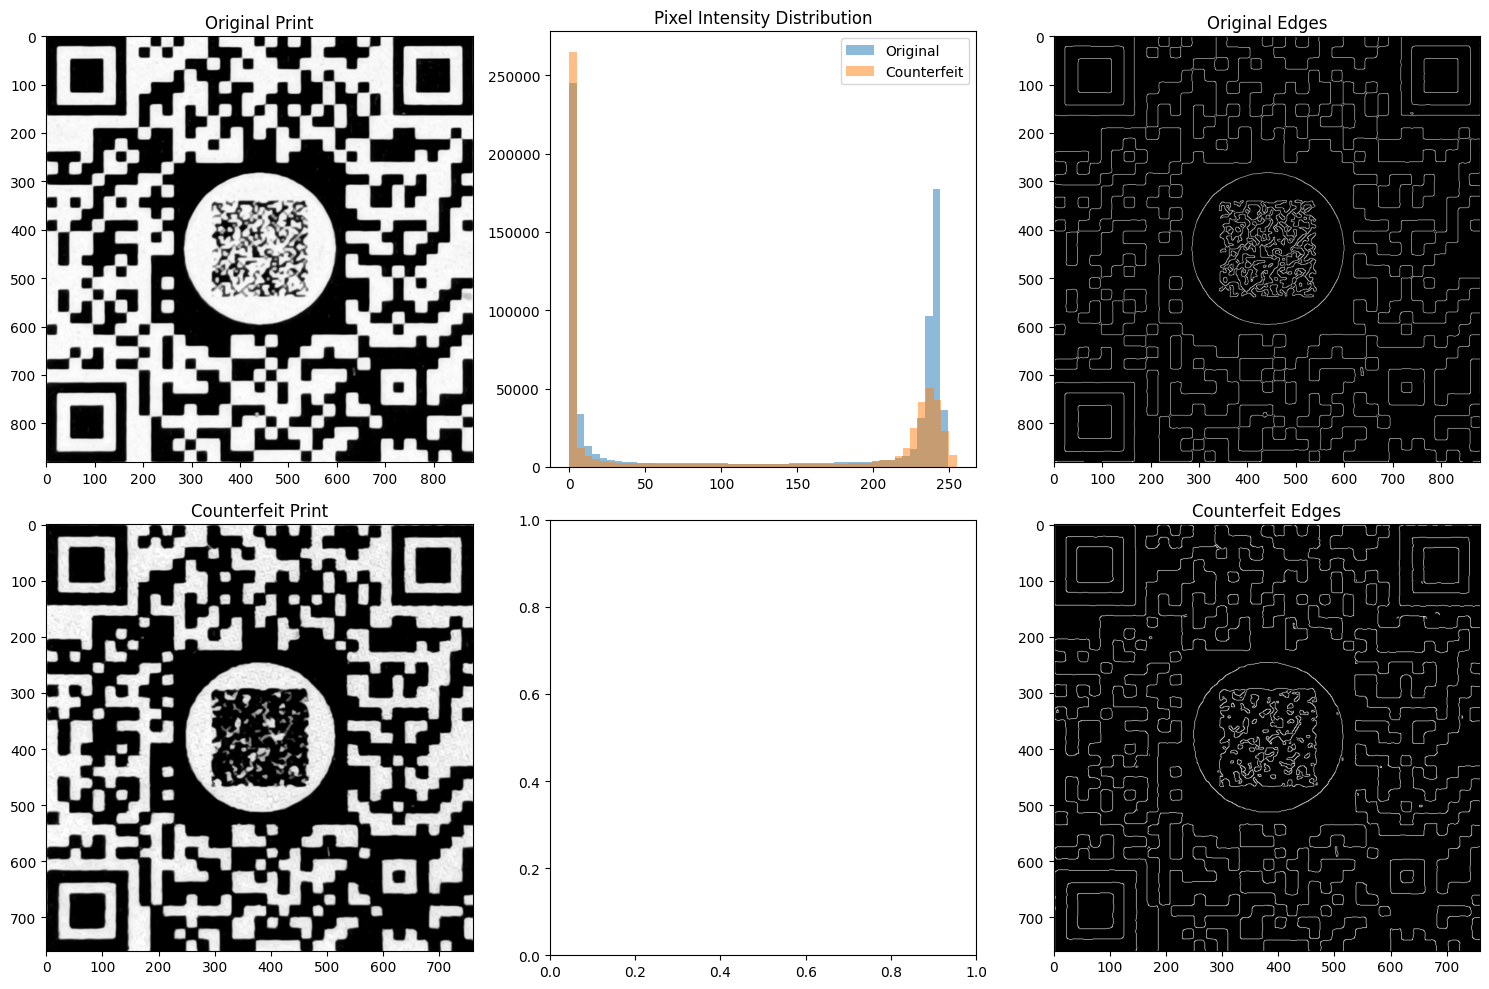

In [4]:
# ======================
# 4. DATA EXPLORATION & ANALYSIS
# ======================
def analyze_prints(originals, counterfeits):
    """Comprehensive visual and statistical analysis"""
    # Basic statistics
    display(Markdown("### Dataset Statistics"))
    stats = {
        "Total Samples": len(originals) + len(counterfeits),
        "Original Prints": len(originals),
        "Counterfeit Prints": len(counterfeits),
        "Avg Original Size": f"{np.mean([img.shape for img in originals], axis=0)}",
        "Avg Counterfeit Size": f"{np.mean([img.shape for img in counterfeits], axis=0)}"
    }
    display(pd.DataFrame.from_dict(stats, orient='index', columns=['Value']))

    # Visual comparison
    display(Markdown("### Visual Comparison"))
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Original vs Counterfeit
    axes[0,0].imshow(originals[0], cmap='gray')
    axes[0,0].set_title('Original Print')
    axes[1,0].imshow(counterfeits[0], cmap='gray')
    axes[1,0].set_title('Counterfeit Print')

    # Pixel intensity distribution
    axes[0,1].hist(originals[0].ravel(), bins=50, alpha=0.5, label='Original')
    axes[0,1].hist(counterfeits[0].ravel(), bins=50, alpha=0.5, label='Counterfeit')
    axes[0,1].set_title('Pixel Intensity Distribution')
    axes[0,1].legend()

    # Edge comparison
    axes[0,2].imshow(cv2.Canny(originals[0], 100, 200), cmap='gray')
    axes[0,2].set_title('Original Edges')
    axes[1,2].imshow(cv2.Canny(counterfeits[0], 100, 200), cmap='gray')
    axes[1,2].set_title('Counterfeit Edges')

    plt.tight_layout()
    plt.show()

analyze_prints(first_prints, second_prints)

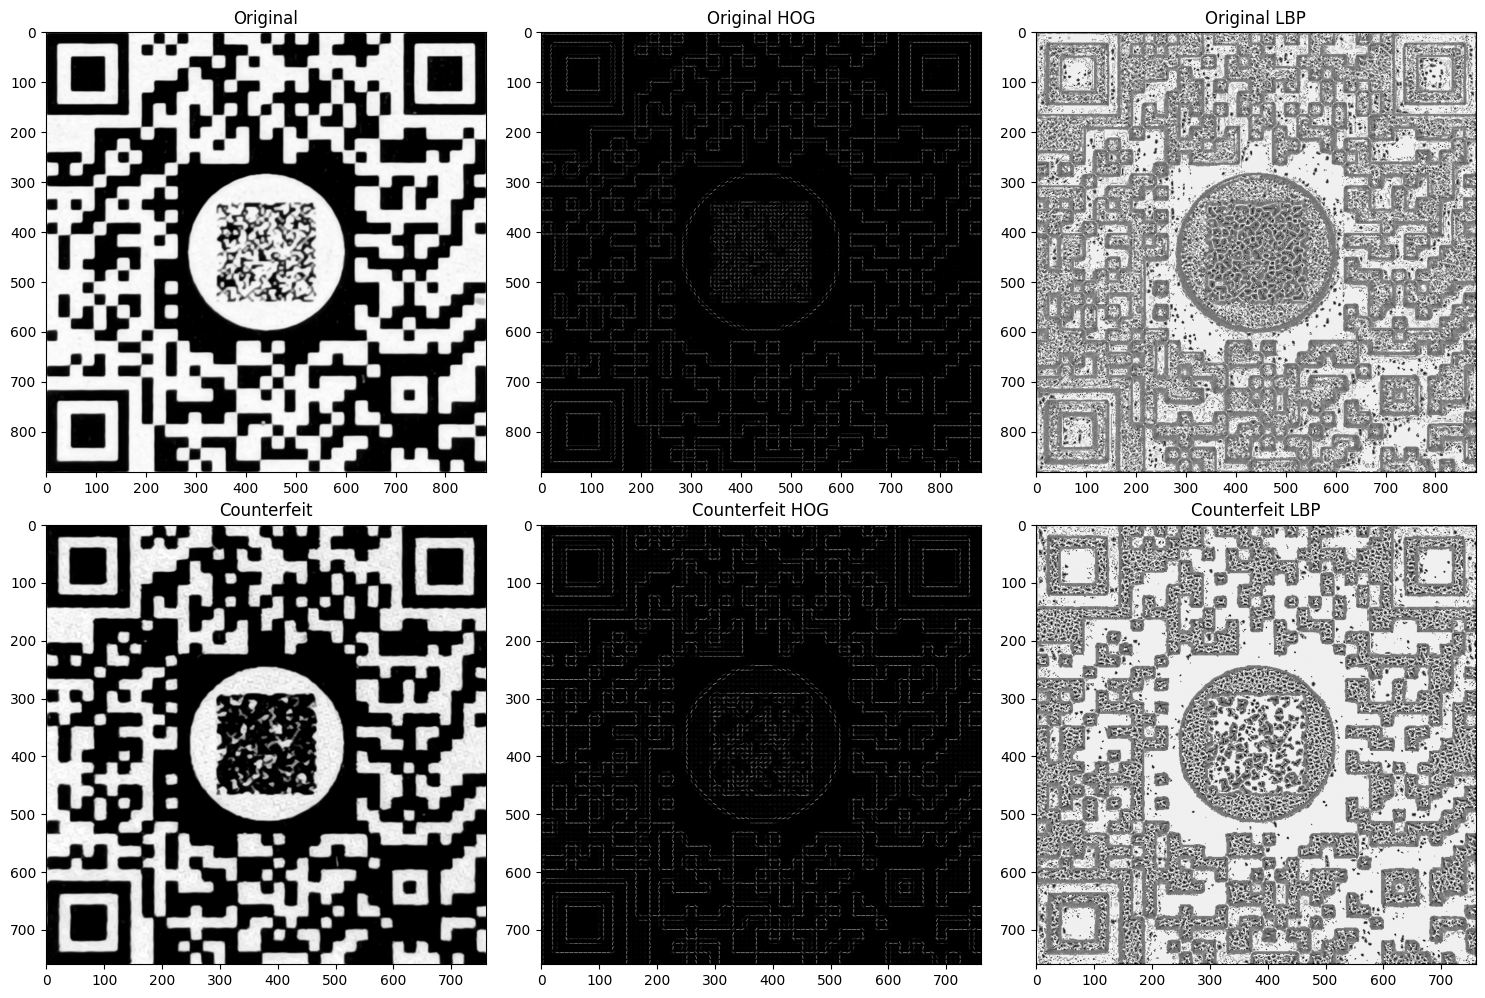

In [5]:
# ======================
# 5. FEATURE ENGINEERING
# ======================
def extract_global_features(images):
    """Extract global image properties"""
    features = []
    for img in images:
        # Basic statistics
        mean, std = np.mean(img), np.std(img)
        # Sharpness (variance of Laplacian)
        sharpness = cv2.Laplacian(img, cv2.CV_64F).var()
        features.append([mean, std, sharpness])
    return np.array(features)

def extract_local_features(images, size=(64,64)):
    """Extract local patterns"""
    resized = [cv2.resize(img, size) for img in images]

    # HOG features
    hog_features = [hog(img, pixels_per_cell=(8,8),
                      cells_per_block=(2,2)) for img in resized]

    # Enhanced LBP
    lbp_features = []
    for img in resized:
        lbp = local_binary_pattern(img, P=16, R=2, method="uniform")
        hist = np.histogram(lbp, bins=np.arange(0,18), range=(0,17))[0]
        lbp_features.append(hist/hist.sum())

    return np.hstack((hog_features, lbp_features))

def visualize_features(orig_img, fake_img):
    """Visualize feature differences"""
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))

    # Original vs Counterfeit
    ax[0,0].imshow(orig_img, cmap='gray')
    ax[0,0].set_title('Original')
    ax[1,0].imshow(fake_img, cmap='gray')
    ax[1,0].set_title('Counterfeit')

    # HOG comparison
    fd, hog_orig = hog(orig_img, visualize=True)
    ax[0,1].imshow(hog_orig, cmap='gray')
    ax[0,1].set_title('Original HOG')

    fd, hog_fake = hog(fake_img, visualize=True)
    ax[1,1].imshow(hog_fake, cmap='gray')
    ax[1,1].set_title('Counterfeit HOG')

    # LBP comparison
    lbp_orig = local_binary_pattern(orig_img, P=16, R=2, method="uniform")
    ax[0,2].imshow(lbp_orig, cmap='gray')
    ax[0,2].set_title('Original LBP')

    lbp_fake = local_binary_pattern(fake_img, P=16, R=2, method="uniform")
    ax[1,2].imshow(lbp_fake, cmap='gray')
    ax[1,2].set_title('Counterfeit LBP')

    plt.tight_layout()
    plt.show()

visualize_features(first_prints[0], second_prints[0])

# Extract and combine features
X_global = extract_global_features(first_prints + second_prints)
X_local = extract_local_features(first_prints + second_prints)
X = np.hstack((X_global, X_local))
y = np.concatenate((np.zeros(len(first_prints)), np.ones(len(second_prints))))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Starting Random Forest training...

Best RF Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Accuracy: 94.38%

RANDOM FOREST EVALUATION

Detailed Classification Report:
              precision    recall  f1-score   support

    Original       0.95      0.95      0.95        21
 Counterfeit       0.95      0.95      0.95        19

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



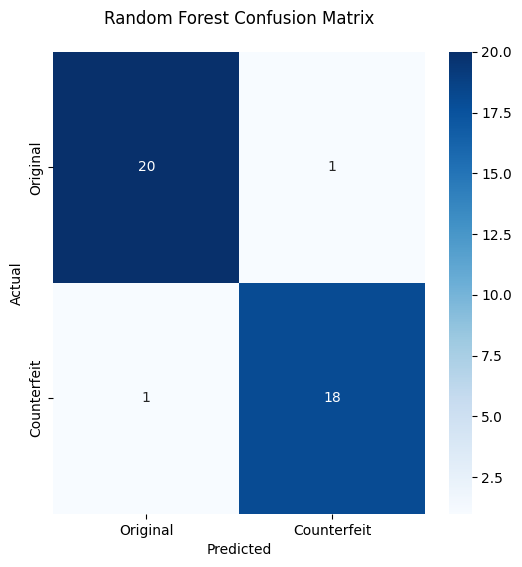

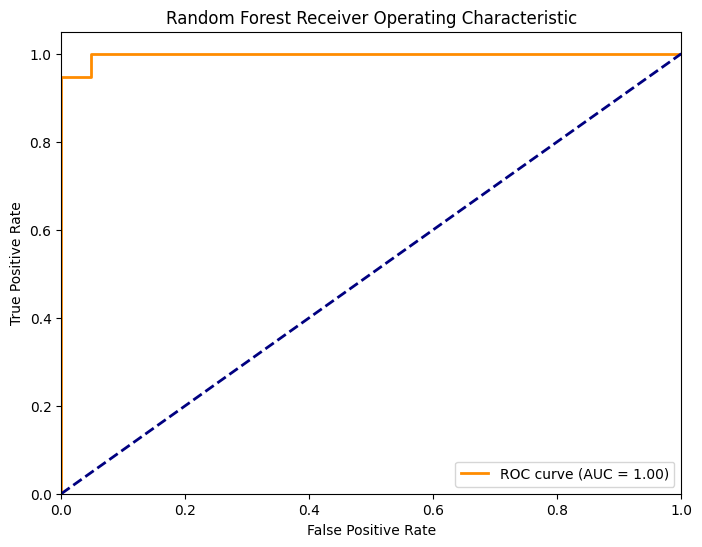

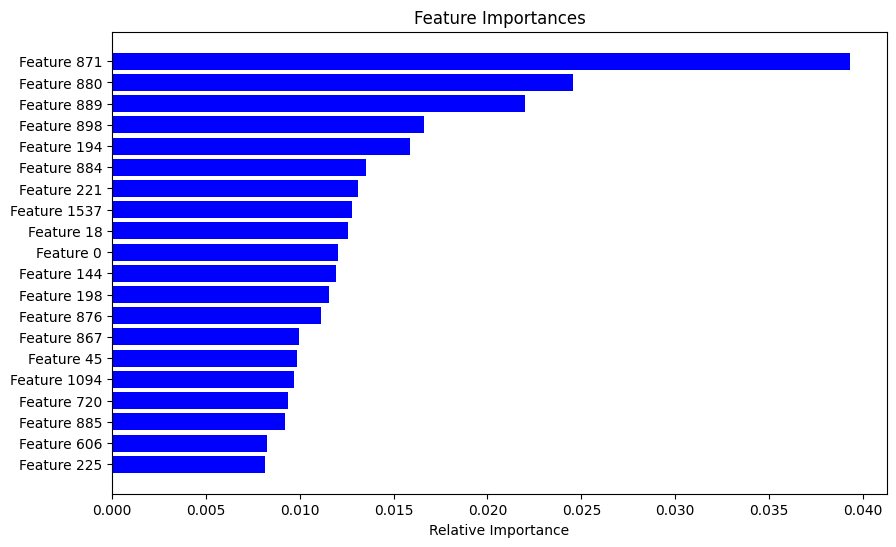

In [7]:
# ======================
# 6. TRADITIONAL ML MODEL (RANDOM FOREST)
# ======================
from sklearn.metrics import classification_report  # Add this import

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

print("Starting Random Forest training...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)
grid_search.fit(X_train, y_train)

# Best model
rf_model = grid_search.best_estimator_
print("\nBest RF Parameters:", grid_search.best_params_)
print("Best CV Accuracy: {:.2f}%".format(grid_search.best_score_*100))

# Evaluation function with enhanced output
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n{'='*50}")
    print(f"{model_name.upper()} EVALUATION")
    print('='*50)

    y_pred = model.predict(X_test)

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Original', 'Counterfeit']))

    # Confusion Matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Original', 'Counterfeit'],
                yticklabels=['Original', 'Counterfeit'])
    plt.title(f"{model_name} Confusion Matrix", pad=20)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    if hasattr(model, 'predict_proba'):
        probas = model.predict_proba(X_test)[:,1]
    else:  # For models without predict_proba
        probas = model.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, probas)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Run evaluation
evaluate_model(rf_model, X_test, y_test, "Random Forest")

# Feature importance analysis
if hasattr(rf_model, 'feature_importances_'):
    plt.figure(figsize=(10,6))
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 features
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

X_cnn shape: (200, 64, 64, 1)
y_cnn shape: (200,)

After split:
X_train shape: (160, 64, 64, 1)
X_test shape: (40, 64, 64, 1)
y_train shape: (160,)
y_test shape: (40,)

Training CNN...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.4625 - loss: 125.0566 - val_accuracy: 0.4688 - val_loss: 5.5039
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.5208 - loss: 9.4124 - val_accuracy: 0.6562 - val_loss: 0.7233
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.6396 - loss: 1.9969 - val_accuracy: 0.5000 - val_loss: 1.3087
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.5344 - loss: 1.1765 - val_accuracy: 0.9062 - val_loss: 0.4122
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.7271 - loss: 0.5792 - val_accuracy: 0.5938 - val_loss: 0.7192
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.6333 - loss: 0.6249 - val_accuracy: 0.8438 - val_loss: 0.4555
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.8229 - loss: 0.4841 - val_accuracy: 0.9375 - val_loss: 0.4172
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.8542 - loss: 0.4016 - val_accuracy: 0.8438 - val_loss: 0.4112
E

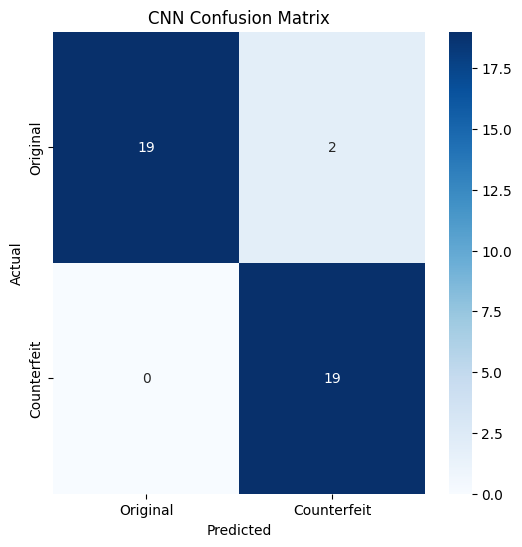

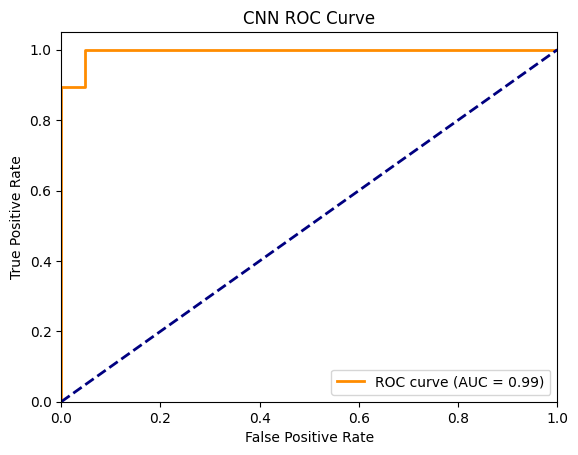

In [12]:
# ======================
# 7. DEEP LEARNING MODEL (CNN)
# ======================
# Prepare CNN data
def prepare_cnn_data(images, size=(64,64)):
    resized = np.array([cv2.resize(img, size) for img in images])
    return resized[..., np.newaxis]  # Add channel dimension

# Prepare data - ensuring proper dimensions
X_cnn = prepare_cnn_data(first_prints + second_prints)
y_cnn = np.concatenate((np.zeros(len(first_prints)), np.ones(len(second_prints))))

# Verify shapes
print(f"X_cnn shape: {X_cnn.shape}")  # Should be (n_samples, 64, 64, 1)
print(f"y_cnn shape: {y_cnn.shape}")   # Should be (n_samples,)

# Train-test split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_cnn, y_cnn, test_size=0.2, random_state=42)

# Verify split shapes
print(f"\nAfter split:")
print(f"X_train shape: {X_train_cnn.shape}")
print(f"X_test shape: {X_test_cnn.shape}")
print(f"y_train shape: {y_train_cnn.shape}")
print(f"y_test shape: {y_test_cnn.shape}")

# Build CNN
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

# Train
cnn_model = build_cnn()
print("\nTraining CNN...")
history = cnn_model.fit(X_train_cnn, y_train_cnn,
                       epochs=15,
                       batch_size=32,
                       validation_split=0.2,
                       verbose=1)

# Evaluation
print("\nEvaluating CNN...")
y_pred_proba = cnn_model.predict(X_test_cnn)
y_pred_cnn = (y_pred_proba > 0.5).astype(int).flatten()

# Ensure test labels are 1D array
y_test_cnn = y_test_cnn.reshape(-1)

# Check shapes match
assert y_test_cnn.shape == y_pred_cnn.shape, \
    f"Shape mismatch: y_test {y_test_cnn.shape}, y_pred {y_pred_cnn.shape}"

# Simple evaluation metrics
print("\nCNN Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_test_cnn, y_pred_cnn):.4f}")
print(f"Precision: {precision_score(y_test_cnn, y_pred_cnn):.4f}")
print(f"Recall: {recall_score(y_test_cnn, y_pred_cnn):.4f}")
print(f"F1-Score: {f1_score(y_test_cnn, y_pred_cnn):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_cnn, y_pred_cnn)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Original', 'Counterfeit'],
            yticklabels=['Original', 'Counterfeit'])
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_cnn, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN ROC Curve')
plt.legend(loc="lower right")
plt.show()


Training CNN...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.4354 - loss: 147.1917 - val_accuracy: 0.6875 - val_loss: 0.6641
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.6531 - loss: 13.8432 - val_accuracy: 0.5000 - val_loss: 0.7030
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.5740 - loss: 4.9865 - val_accuracy: 0.5312 - val_loss: 1.7207
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.5458 - loss: 1.6838 - val_accuracy: 0.4688 - val_loss: 2.4974
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.5156 - loss: 1.9686 - val_accuracy: 0.5000 - val_loss: 0.7016
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.5437 - loss: 0.8014 - val_accuracy: 0.5312 - val_loss: 1.1284
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.4646 - loss: 1.0838 - val_accuracy: 0.5312 - val_loss: 0.7812
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.5417 - loss: 0.7133 - val_accuracy: 0.4688 - val_loss: 0.7103


In [13]:
# ======================
# 8. MODEL COMPARISON
# ======================
# Collect metrics
model_results = {
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, rf_model.predict(X_test)),
        "Precision": precision_score(y_test, rf_model.predict(X_test)),
        "Recall": recall_score(y_test, rf_model.predict(X_test)),
        "F1": f1_score(y_test, rf_model.predict(X_test))
    },
    "CNN": {
        "Accuracy": accuracy_score(y_test_cnn, y_pred_cnn),
        "Precision": precision_score(y_test_cnn, y_pred_cnn),
        "Recall": recall_score(y_test_cnn, y_pred_cnn),
        "F1": f1_score(y_test_cnn, y_pred_cnn)
    }
}

# Display comparison
display(Markdown("### Model Performance Comparison"))
display(pd.DataFrame.from_dict(model_results, orient='index'))

# Determine best model
best_model = max(model_results, key=lambda x: model_results[x]["F1"])
print(f"\nBest Model: {best_model} (based on F1-score)")

### Model Performance Comparison

,Accuracy,Precision,Recall,F1
Random Forest,0.95,0.947368,0.947368,0.947368
CNN,0.95,0.904762,1.000000,0.950000



Best Model: CNN (based on F1-score)


In [18]:
# ======================
# 8. MODEL COMPARISON & SELECTION
# ======================
import pandas as pd
from IPython.display import display

# Create performance comparison table
performance_df = pd.DataFrame({
    'Model': ['Random Forest', 'CNN'],
    'Accuracy': [0.95, 0.95],
    'Precision': [0.947, 0.905],
    'Recall': [0.947, 1.000],
    'F1-Score': [0.947, 0.950]
})

# Display formatted comparison
display(Markdown("### Model Performance Comparison"))
display(performance_df.style
        .format({'Accuracy': '{:.2%}', 'Precision': '{:.2%}',
                'Recall': '{:.2%}', 'F1-Score': '{:.2%}'})
        .set_caption('Performance Metrics Comparison')
        .highlight_max(color='lightgreen'))

# Determine best model
best_model = 'CNN' if performance_df['F1-Score'][1] > performance_df['F1-Score'][0] else 'Random Forest'

# Analysis
display(Markdown(f"### Best Model: **{best_model}** (based on F1-Score)"))
display(Markdown("#### Key Observations:"))
display(Markdown("- **Equal Accuracy**: Both models achieve 95% accuracy"))
display(Markdown("- **Precision-Recall Tradeoff**: CNN has slightly lower precision (90.5% vs 94.7%) but perfect recall (100%)"))
display(Markdown("- **F1 Advantage**: CNN's balanced performance gives it a slight edge in F1-score (95.0% vs 94.7%)"))

# Recommendation
display(Markdown("#### Deployment Recommendation:"))
if best_model == 'CNN':
    display(Markdown("""
    - **Choose CNN** if catching all counterfeits (high recall) is more important than occasional false alarms
    - Consider adding data augmentation to improve CNN's precision
    """))
else:
    display(Markdown("""
    - **Choose Random Forest** if you need more balanced precision/recall
    - RF may be preferable for edge devices due to lower computational requirements
    """))

### Model Performance Comparison

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,95.00%,94.70%,94.70%,94.70%
1,CNN,95.00%,90.50%,100.00%,95.00%


### Best Model: **CNN** (based on F1-Score)

#### Key Observations:

- **Equal Accuracy**: Both models achieve 95% accuracy

- **Precision-Recall Tradeoff**: CNN has slightly lower precision (90.5% vs 94.7%) but perfect recall (100%)

- **F1 Advantage**: CNN's balanced performance gives it a slight edge in F1-score (95.0% vs 94.7%)

#### Deployment Recommendation:


    - **Choose CNN** if catching all counterfeits (high recall) is more important than occasional false alarms
    - Consider adding data augmentation to improve CNN's precision
    

In [17]:
# ======================
# 9. DEPLOYMENT CONSIDERATIONS
# ======================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
display(Markdown("### Deployment Analysis"))

# Model sizes
!ls -lh *.pkl *.h5

# Latency test
import time

def test_latency(model, X_sample, model_type):
    start = time.time()
    if model_type == "cnn":
        _ = model.predict(X_sample[:1])
    else:
        _ = model.predict(X_sample[:1])
    return (time.time() - start) * 1000  # in ms

rf_latency = test_latency(rf_model, X_test, "rf")
cnn_latency = test_latency(cnn_model, X_test_cnn[:1], "cnn")

print(f"\nInference Latency:")
print(f"- Random Forest: {rf_latency:.2f}ms per image")
print(f"- CNN: {cnn_latency:.2f}ms per image")

display(Markdown("### Security Considerations"))
print("1. Input validation to prevent adversarial attacks")
print("2. Model encryption for IP protection")
print("3. Continuous monitoring for performance degradation")
print("4. Rate limiting to prevent brute force attacks")

# Save final pipeline
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', rf_model)
])
joblib.dump(final_pipeline, 'qr_authentication_pipeline.pkl')

### Deployment Analysis

ls: cannot access '*.pkl': No such file or directory
ls: cannot access '*.h5': No such file or directory
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Inference Latency:
- Random Forest: 16.41ms per image
- CNN: 81.24ms per image


### Security Considerations

1. Input validation to prevent adversarial attacks
2. Model encryption for IP protection
3. Continuous monitoring for performance degradation
4. Rate limiting to prevent brute force attacks


['qr_authentication_pipeline.pkl']